In [2]:
import pandahouse as ph
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
# Далее создаем словарь `connection` с нужными параметрами:

connection = {'host': 'https://clickhouse.lab.karpov.courses',
              'database':'default',
              'user':'student', 
              'password':'dpo_python_2020'
                     }

In [ ]:
# проверим правильность подключения к ClickHouse через pandahouse, 
# отправив простой запрос: выведите количество строк в таблице ldn_listings.

In [3]:
query = """
SELECT count(id)
FROM default.ldn_listings

"""

# записываем результат в пандасовский датафрейм
df_ldn = ph.read_clickhouse(query, connection=connection)
df_ldn

,count(id)
0,85207


In [ ]:
Выгрузите из таблицы данные о цене в зависимости от типа жилья. Необходимые столбцы:
price – цена за ночь
room_type – тип сдаваемого жилья
Ограничение поставьте на 1000 строк. Результат должен быть отсортирован по возрастанию id.

In [6]:
query2 = """
SELECT  room_type, 
        toFloat64OrNull(replaceRegexpAll(price, '[$,]', '')) as price
FROM default.ldn_listings
ORDER BY id
LIMIT 1000
"""

df_room_price = ph.read_clickhouse(query2, connection=connection)
df_room_price   

,room_type,price
0,Private room,65.0
1,Entire home/apt,100.0
2,Entire home/apt,300.0
3,Private room,150.0
4,Entire home/apt,65.0
...,...,...
995,Entire home/apt,110.0
996,Entire home/apt,110.0
997,Private room,65.0
998,Entire home/apt,100.0


In [ ]:
# Сгруппируйте полученный датафрейм по типу жилья и посчитайте 75-й перцентиль цены.
# В качестве ответа впишите полученное значение 75 перцентиля цены для комнат типа Private room.

In [7]:
percentile = df_room_price.groupby('room_type').price.quantile(q=0.75)
percentile

room_type
Entire home/apt    160.00
Hotel room         157.00
Private room        70.00
Shared room         69.25
Name: price, dtype: float64

In [ ]:
# К данным о цене и типе комнаты дополнительно выгрузите данные о рейтинге жилья 
(review_scores_rating)

In [10]:
query3 = """
SELECT  room_type, 
        toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) as price,
        toFloat32OrNull(review_scores_rating) as review_scores_rating
FROM default.ldn_listings
WHERE review_scores_rating is not NULL
ORDER BY id
LIMIT 1000
"""

df_rev_price = ph.read_clickhouse(query3, connection=connection)
df_rev_price  

,room_type,price,review_scores_rating
0,Private room,65.0,97.0
1,Entire home/apt,100.0,96.0
2,Entire home/apt,300.0,94.0
3,Entire home/apt,65.0,93.0
4,Private room,29.0,96.0
...,...,...,...
995,Entire home/apt,165.0,100.0
996,Private room,99.0,93.0
997,Private room,45.0,100.0
998,Private room,20.0,88.0


In [ ]:
# сгруппируйте датафрейм по типу жилья и посчитайте среднее для цены и рейтинга 
# (не забудьте привести рейтинг к типу float)

In [12]:
avg_df = df_rev_price.groupby('room_type', as_index=False).agg({'price' : 'mean', 'review_scores_rating' : 'mean'})
avg_df

,room_type,price,review_scores_rating
0,Entire home/apt,135.882950,93.568787
1,Hotel room,134.000000,92.500000
2,Private room,54.642437,94.766205
3,Shared room,21.000000,90.000000


In [ ]:
# Давайте построим график рассеивания, который покажет 
# зависимость средней оценки от средней цены по типу жилья.

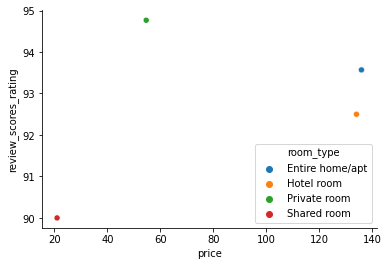

In [13]:
sns.scatterplot(data=avg_df, x="price", y="review_scores_rating", hue="room_type")
sns.despine()

In [ ]:
помимо аренды жилья, на Airbnb также есть мероприятия, которые организуют местные жители.
Проверим, какие способы верификации аккаунта использовали хозяева, предлагающие различные впечатления (experiences_offered != 'none'). 
Для каждого уникального пользователя выгрузите только две колонки:
host_id – идентификатор хозяина (уникальный)
host_verifications – какими способами хост подтвердил свой профиль

Затем обработайте столбец host_verifications:
1. В ячейках находятся строковые представления списка (например, как результат str([1, 2, 3])). 
Приведите их к настоящему списку, где в качестве элементов будут храниться использованные способы подтверждения аккаунта: 
    "['email', 'phone', 'facebook']" -> ['email', 'phone', 'facebook']
2. Используйте методы explode и value_counts, чтобы посчитать, сколько раз встречается каждый способ верификации

Сколько хозяев подтвердили профиль с помощью аккаунта Google?

In [18]:
query4 = """
SELECT  DISTINCT host_id as host_id, 
        host_verifications
FROM default.ldn_listings
WHERE experiences_offered != 'none'
"""

df_ver = ph.read_clickhouse(query4, connection=connection)
df_ver

,host_id,host_verifications
0,54730,"['email', 'phone', 'facebook', 'reviews', 'off..."
1,60302,"['email', 'phone', 'reviews', 'jumio', 'govern..."
2,67915,"['email', 'phone', 'jumio', 'selfie', 'governm..."
3,167107,"['email', 'phone', 'manual_offline', 'jumio', ..."
4,103583,"['email', 'phone', 'reviews', 'offline_governm..."
...,...,...
1356,21558962,"['email', 'phone', 'reviews', 'jumio', 'govern..."
1357,21257846,"['email', 'phone', 'reviews', 'jumio', 'offlin..."
1358,34219613,"['email', 'phone', 'reviews', 'jumio', 'govern..."
1359,34299581,"['email', 'phone', 'google', 'reviews', 'jumio..."


In [19]:
def list_func(x):
    lst = x[1:-1].replace("'", "").split(',')
    return lst 

df_ver['host_verifications'] = df_ver['host_verifications'].apply(list_func)
df_ver['host_verifications']

0       [email,  phone,  facebook,  reviews,  offline_...
1       [email,  phone,  reviews,  jumio,  government_id]
2       [email,  phone,  jumio,  selfie,  government_i...
3       [email,  phone,  manual_offline,  jumio,  offl...
4       [email,  phone,  reviews,  offline_government_...
                              ...                        
1356    [email,  phone,  reviews,  jumio,  government_id]
1357    [email,  phone,  reviews,  jumio,  offline_gov...
1358    [email,  phone,  reviews,  jumio,  government_id]
1359    [email,  phone,  google,  reviews,  jumio,  of...
1360    [email,  phone,  reviews,  manual_offline,  ju...
Name: host_verifications, Length: 1361, dtype: object

In [20]:
df_exploded = df_ver.explode('host_verifications')
df_exploded

,host_id,host_verifications
0,54730,email
0,54730,phone
0,54730,facebook
0,54730,reviews
0,54730,offline_government_id
...,...,...
1360,26917573,phone
1360,26917573,reviews
1360,26917573,manual_offline
1360,26917573,jumio


In [21]:
# Сколько хозяев подтвердили профиль с помощью аккаунта Google?

df_exploded.host_verifications.value_counts()

 phone                    1345
email                     1345
 reviews                  1309
 government_id            1196
 jumio                    1115
 offline_government_id     469
 work_email                279
 facebook                  270
 selfie                    252
 identity_manual           227
 manual_offline             70
 google                     34
 kba                        27
phone                       16
 manual_online              16
 sent_id                     6
Name: host_verifications, dtype: int64

In [ ]:
для скольких объявлений и в каких районах хозяева указали впечатления. 
Сгруппируйте данные по району и виду впечатления и посчитайте количество объявлений. 
Новый столбец назовите experiences_count.

Отсортируйте данные по убыванию experiences_count и выгрузите первые 100 строк. 
Затем преобразуйте данные с помощью pivot, поместив в индексы название района, 
столбцы – вид впечатления, а значения – число объявлений с таким впечатлением для каждого района. 
Визуализируйте результат с помощью sns.heatmap() c палитрой cmap=sns.cubehelix_palette(as_cmap=True). 

In [32]:
query5 = """
SELECT  
    neighbourhood_cleansed,
    experiences_offered,
    COUNT(id) as experiences_count
FROM default.ldn_listings
WHERE experiences_offered != 'none'
GROUP BY 
    neighbourhood_cleansed,
    experiences_offered
ORDER BY experiences_count DESC
LIMIT 100
"""

df_exp_neib = ph.read_clickhouse(query5, connection=connection)
df_exp_neib

,neighbourhood_cleansed,experiences_offered,experiences_count
0,Hackney,family,61
1,Tower Hamlets,business,58
2,Westminster,business,50
3,Hackney,social,49
4,Hammersmith and Fulham,business,48
...,...,...,...
95,Redbridge,social,2
96,Barking and Dagenham,social,2
97,Newham,romantic,1
98,Bexley,business,1


In [31]:
# the same in python

df_exp_type = df_exp_neib.groupby(['neighbourhood_cleansed', 'experiences_offered'], as_index=False) \
                    .agg({'experiences_count' : 'sum'}) \
                    .sort_values('experiences_count', ascending=False)
# df_exp_type

,neighbourhood_cleansed,experiences_offered,experiences_count
31,Hackney,family,61
85,Tower Hamlets,business,58
96,Westminster,business,50
33,Hackney,social,49
34,Hammersmith and Fulham,business,48
...,...,...,...
26,Enfield,social,2
0,Barking and Dagenham,social,2
71,Newham,romantic,1
5,Bexley,business,1


In [33]:
# преобразуем в сводную таблицу

pivot_df = df_exp_neib.pivot(index='neighbourhood_cleansed', 
                              columns='experiences_offered', 
                              values='experiences_count') \
                       .fillna(0)
pivot_df 

experiences_offered,business,family,romantic,social
neighbourhood_cleansed,,,,
Barking and Dagenham,0.0,0.0,0.0,2.0
Barnet,7.0,7.0,3.0,5.0
Bexley,1.0,0.0,0.0,0.0
Brent,9.0,21.0,5.0,6.0
Bromley,3.0,2.0,0.0,4.0
Camden,36.0,30.0,19.0,25.0
City of London,7.0,1.0,0.0,0.0
Croydon,2.0,3.0,0.0,4.0
Ealing,6.0,13.0,0.0,5.0


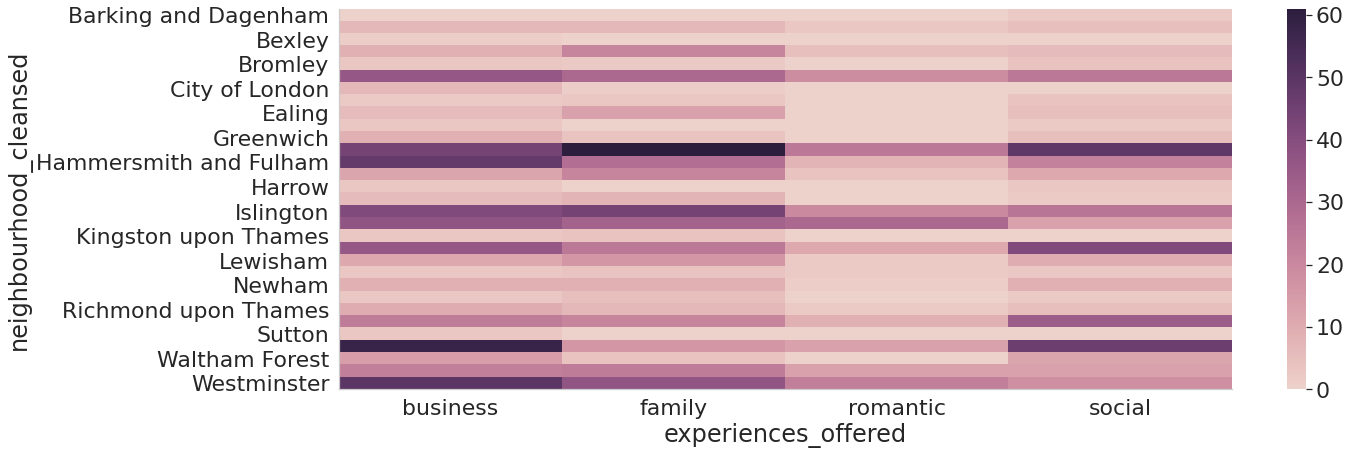

In [36]:
# строим диаграму sns.heatmap()

sns.set(
        font_scale =2,
        style      ="whitegrid",
        rc         ={'figure.figsize':(20,7)}
       )     # настраиваем                              

cmap=sns.cubehelix_palette(as_cmap=True)    # палитра
sns.heatmap(pivot_df, cmap=cmap)
sns.despine()

In [ ]:
Выгрузите данные о ценах за ночь для разных типов жилья, для которых также доступен какой-либо вид впечатления. 
Необходимые для составления запроса столбцы:
room_type – тип сдаваемого жилья
price – цена за ночь 
experiences_offered – вид доступного впечатления (оставить не 'none')

In [37]:
query6 = """
SELECT  
    room_type,
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) as price
FROM default.ldn_listings
WHERE experiences_offered != 'none'
"""

df_type_price = ph.read_clickhouse(query6, connection=connection)
df_type_price

,room_type,price
0,Private room,65.0
1,Entire home/apt,100.0
2,Private room,150.0
3,Private room,45.0
4,Private room,25.0
...,...,...
1543,Entire home/apt,100.0
1544,Entire home/apt,125.0
1545,Entire home/apt,185.0
1546,Entire home/apt,110.0


In [ ]:
#  постройте два графика, используя distplot из библиотеки seaborn:
#  На первом отобразите исходные распределения цен для каждого типа жилья
#  На втором – логарифмированные значения (np.log())

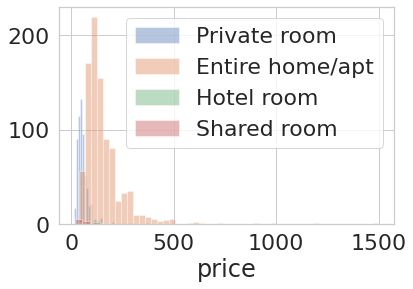

In [43]:
sns.distplot(df_type_price.query("room_type == 'Private room'").price, kde=False, label='Private room')
sns.distplot(df_type_price.query("room_type == 'Entire home/apt'").price, kde=False, label='Entire home/apt')
sns.distplot(df_type_price.query("room_type == 'Hotel room'").price, kde=False, label='Hotel room')
sns.distplot(df_type_price.query("room_type == 'Shared room'").price, kde=False, label='Shared room')
plt.legend()
plt.show()

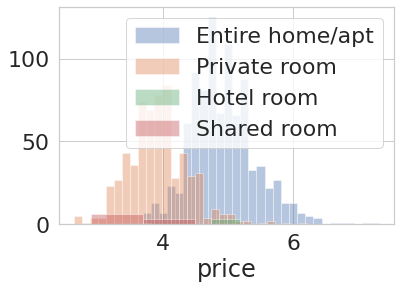

In [44]:
sns.distplot(np.log(df_type_price.query("room_type == 'Entire home/apt'").price), kde=False, label='Entire home/apt')
sns.distplot(np.log(df_type_price.query("room_type == 'Private room'").price), kde=False, label='Private room')
sns.distplot(np.log(df_type_price.query("room_type == 'Hotel room'").price), kde=False, label='Hotel room')
sns.distplot(np.log(df_type_price.query("room_type == 'Shared room'").price), kde=False, label='Shared room')
plt.legend()
plt.show()

In [ ]:
Выгрузите данные о цене, типе жилья и дате первого отзыва, начиная со 2 января 2010 года. 
Необходимые столбцы:
room_type – тип сдаваемого жилья
price – цена за ночь
first_review – дата первого отзыва (отфильтровать по правилу "строго больше 2010-01-01")
Ограничение поставьте на 1000 строк.

In [5]:
query7 = """
SELECT  
    room_type,
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) as price,
    first_review
FROM default.ldn_listings
WHERE first_review > '2010-01-01'
LIMIT 1000
"""

df_rev= ph.read_clickhouse(query7, connection=connection)
df_rev

,room_type,price,first_review
0,Private room,65.0,2010-08-18
1,Entire home/apt,300.0,2011-03-21
2,Entire home/apt,65.0,2016-03-05
3,Private room,29.0,2010-04-14
4,Private room,100.0,2010-10-16
...,...,...,...
995,Private room,45.0,2012-11-07
996,Private room,51.0,2013-03-18
997,Entire home/apt,79.0,2012-09-17
998,Entire home/apt,110.0,2012-09-24


In [7]:
df_rev['first_review'] = df_rev.first_review.apply(lambda x: x[:4])
df_rev

,room_type,price,first_review
0,Private room,65.0,2010
1,Entire home/apt,300.0,2011
2,Entire home/apt,65.0,2016
3,Private room,29.0,2010
4,Private room,100.0,2010
...,...,...,...
995,Private room,45.0,2012
996,Private room,51.0,2013
997,Entire home/apt,79.0,2012
998,Entire home/apt,110.0,2012


In [9]:
avg_price = df_rev.groupby(['room_type', 'first_review'], as_index=False).agg({'price':'mean'})
avg_price

,room_type,first_review,price
0,Entire home/apt,2010,103.500000
1,Entire home/apt,2011,128.792450
2,Entire home/apt,2012,135.467255
3,Entire home/apt,2013,137.887634
4,Entire home/apt,2014,154.583328
5,Entire home/apt,2015,159.380951
6,Entire home/apt,2016,99.733330
7,Entire home/apt,2017,111.666664
8,Entire home/apt,2018,125.066666
9,Entire home/apt,2019,301.666656


In [ ]:
#  Используя библиотеку seaborn и функцию lineplot, 
#  постройте график динамики средних цен на жилье (ось Y) 
#  в зависимости от типа комнаты (цвет линии, параметр 'hue') по годам (ось X). 
#  Датафрейм должен быть отсортирован по годам.

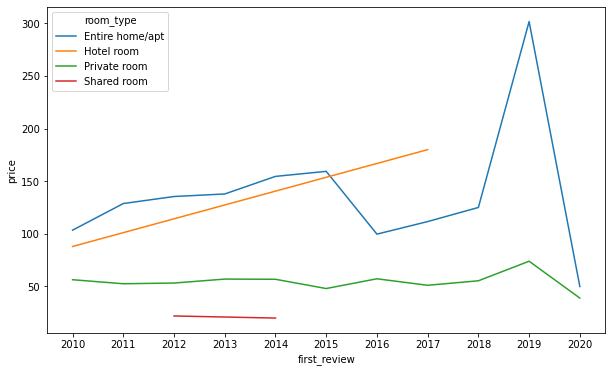

In [11]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='first_review',y='price',hue='room_type',data=avg_price)